# Field methods in remote sensing: Modelling of leaf spectra

- **Prerequisites:** You should have access to the data collected in the field and in the laboratory. You should have finished practical 9.1_ENGN3903_Modelling_Leaf_spectra, and should have access to Google Earth Engine.


## Aims of the practical session

The aim of this practical is to show the differences between satellite spectra, simulated leaf spectra, and leaf spectra collected in the field.

For this activity, we will use the data you collected in the field, the simulated spectra from previous the practical, and Sentinel 2 data from Google Earth Engine.  

## Description

To achieve the aims above, 

First we will:
- Load a Sentinel 2 image of the Arboretum region.
- Plot the leaf spectra collected in the field,
- Plot the simulated leaf spectra from PROSPECT

Then we will:
- Compare the simulated spectra and spectra collected in the field with the spectral signature of a Sentinel 2 image collected over the Arboretum.

Finally you will answer some questions.

Let's do it!

***

## Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os
import glob
import ee
import geemap as gmap

### Connect to Google Earth Engine (GEE)

Connect to the GEE so we can access GEE datasets and computing assets.
You may be required to input your Google account name and password. Please keep those safe and don't share them with anyone.

In [2]:
m = gmap.Map()

## Analysis Parameters

In [3]:
# a short date-range around the time you want the image for
date_range = '2023-09-01','2023-09-30'

#A geojson that defines the analysis extent
geojson = 'https://raw.githubusercontent.com/nicolasyounes/engn3903/main/week8/anu_research_forest.geojson'

#the bands from Sentinel-2 that you want
bands = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']

#The Projection system to save the data in
crs = 'EPSG:3577'

## Open Geometery defining AOI

In [4]:
geometry = gmap.geojson_to_ee(geojson)

Downloading...
From: https://raw.githubusercontent.com/nicolasyounes/engn3903/main/week8/anu_research_forest.geojson
To: /jobfs/96864316.gadi-pbs/98197ea5-953f-4802-9364-0ffeee1a41a3.geojson
648B [00:00, 539kB/s]                    


## Load Sentinel 2 image

In [5]:
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
        .And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    
    return image.updateMask(mask).divide(10000) #re-scale 


s2 = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(geometry)
    .filterDate(date_range[0], date_range[1]) 
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) #filter out very cloudy images
    .map(maskS2clouds) #map the cloudmasking/rescaling function
    .select(bands)
    .median() #collapse time-dimension using median statistic
    .clip(geometry)
)

## Visualize image

In [6]:
# Lastly, let's give some visualization paramaters to each collection.
s2VisParam = {'bands': ["B4","B3","B2"],
              'max': 0.3,
              'min': 0}


# Let's add the polygon to the map
Map = gmap.Map(center=[-35.30339, 149.06204], zoom=15)              
Map.addLayer(s2, s2VisParam, 's2')
Map.addLayerControl()
Map

Map(center=[-35.30339, 149.06204], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox…

## Extract the spectral signature of trees in the Arboretum.

Here, we'll create a pandas DataFrame indexed by Land Cover Type.  Locate the Eucalyptus forest in the Arboretum, and add it to the list of land covers, use the inspector tool to find the values of several pixels of the Eucalyptus forest.  Add the values from the inspector tool to the 'pixelValues' dictionary. You can also add other vegetation types for comparison.

**Excercise tip:** Use all bands except for (B1, B9, and B10) for this excercise. You can find more information [here](https://docs.dea.ga.gov.au/notebooks/DEA_products/DEA_Sentinel2_Surface_Reflectance.html), and [here](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/spectral).

**Excercise tip:** If you need to remember how to do this, look at the practicals from week 2.




In [7]:
#the bands from Sentinel-2 that you want (add more than this!)
bands = ['B2','B3','B4','B7']

#Enter a few repeated pixel values for a series of landcover types
pixel_values = {
    # Landcover : [b2-value, b3-value, etc.]
    'Eucalypt1' :[0.3 , 0.5, 0.2, 0.1],
    'Eucalypt2' :[0.8, .3, .02, .2],
    'Eucalypt3':[.08, .04, .3, .3],
    'Eucalypt4':[0, .5, .4, .3],
}

#combine the data into a pandas dataframe
df_sentinel  = pd.DataFrame(pixel_values, index=bands)
df_sentinel .head()

,Eucalypt1,Eucalypt2,Eucalypt3,Eucalypt4
B2,0.3,0.80,0.08,0.0
B3,0.5,0.30,0.04,0.5
B4,0.2,0.02,0.30,0.4
B7,0.1,0.20,0.30,0.3


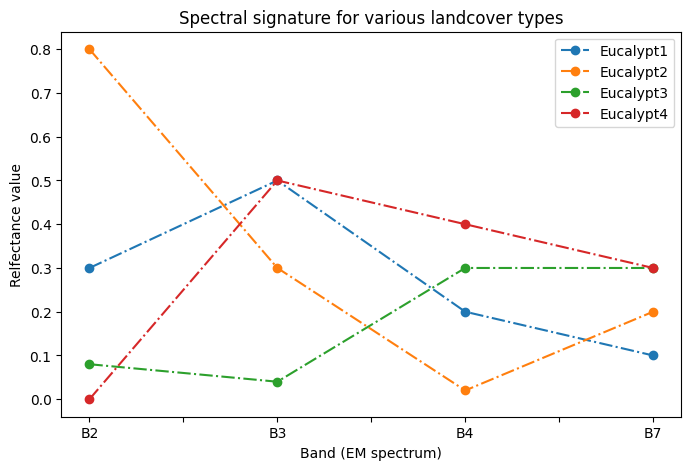

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
df_sentinel .plot(ax=ax, marker='o', linestyle='-.')
ax.legend()
ax.set_title('Spectral signature for various landcover types')
ax.set_xlabel('Band (EM spectrum)')
ax.set_ylabel('S2 Relfectance value');

## Plot the simulated and field leaf spectra

See practical 9.1_ENGN3903_Modelling_Leaf_spectra if you need a refresher on how to do this.

You will use the following files:

`prospectSimulatedSpectra_Cab.csv` - leaf reflectance using different Chlorophyll a and Chlorophyll b concentrations.

`prospectSimulatedSpectra_Car.csv` - leaf reflectance using different Carotenoid concentrations

`prospectSimulatedSpectra_DMC.csv` - leaf reflectance using different Dry Matter Content (DMC) values

`prospectSimulatedSpectra_EWT.csv` - leaf reflectance using different Equivalent Water Thickness (EWT) values

`prospectSimulatedSpectra_FMC.csv` - leaf reflectance using different Fuel Moisture Content (EWT) calculated using the DMC and EWT.

In [9]:
# Change the folder path to whereever you saved the spectra from PROSPECT
folder = '/scratch/du53/cb3058/engn3903/week9/simulated/' 

df_cab = pd.read_csv(folder+'prospectSimulatedSpectra_Cab.csv')
df_cab

,Wavelength,Chloro_0,Chloro_1,Chloro_2,Chloro_3,Chloro_4,Chloro_5,Chloro_6,Chloro_7,Chloro_8,...,Chloro_71,Chloro_72,Chloro_73,Chloro_74,Chloro_75,Chloro_76,Chloro_77,Chloro_78,Chloro_79,Chloro_80
0,400,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,...,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078
1,401,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,...,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078
2,402,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,...,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078
3,403,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,...,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078
4,404,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,...,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078,0.043078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,2496,0.015303,0.015303,0.015303,0.015303,0.015303,0.015303,0.015303,0.015303,0.015303,...,0.015303,0.015303,0.015303,0.015303,0.015303,0.015303,0.015303,0.015303,0.015303,0.015303
2097,2497,0.015323,0.015323,0.015323,0.015323,0.015323,0.015323,0.015323,0.015323,0.015323,...,0.015323,0.015323,0.015323,0.015323,0.015323,0.015323,0.015323,0.015323,0.015323,0.015323
2098,2498,0.015342,0.015342,0.015342,0.015342,0.015342,0.015342,0.015342,0.015342,0.015342,...,0.015342,0.015342,0.015342,0.015342,0.015342,0.015342,0.015342,0.015342,0.015342,0.015342
2099,2499,0.015361,0.015361,0.015361,0.015361,0.015361,0.015361,0.015361,0.015361,0.015361,...,0.015361,0.015361,0.015361,0.015361,0.015361,0.015361,0.015361,0.015361,0.015361,0.015361


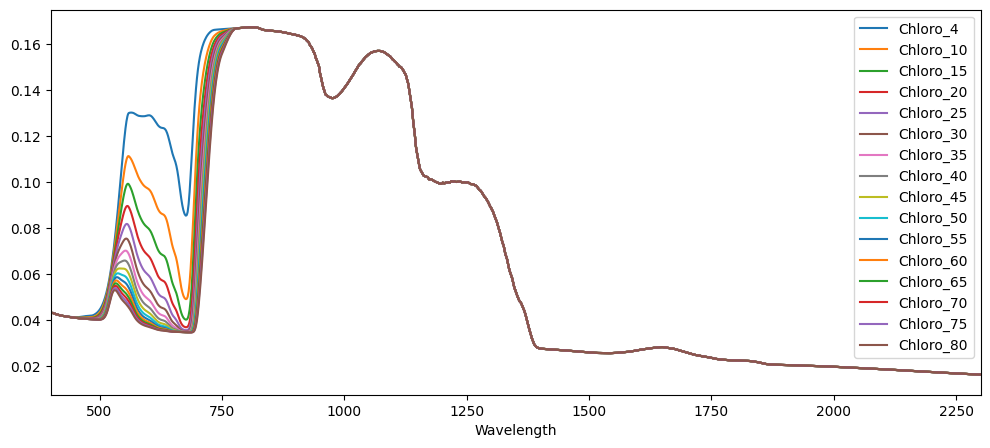

In [10]:
fig, ax = plt.subplots(figsize=(12,5))

df_cab.plot.line(x='Wavelength', y=['Chloro_4', 
       'Chloro_10', 
       'Chloro_15',
       'Chloro_20', 
       'Chloro_25', 
       'Chloro_30',
       'Chloro_35',
       'Chloro_40', 
       'Chloro_45',
       'Chloro_50', 
       'Chloro_55', 
       'Chloro_60', 
       'Chloro_65', 
       'Chloro_70', 
       'Chloro_75', 
       'Chloro_80'], ax=ax)
ax.set_xlim(400,2300)
plt.show()

## Load and Plot the measured spectra

In [11]:
# Load the measured spectra from the 'measured' forlder
# remember to change the names of the files you're using.
meas_folder = '/scratch/du53/cb3058/engn3903/week9/measured/'

measured_spectra1 = pd.read_csv(meas_folder+'MAC_ARB_098_334_210602_L00004.asd.txt',
                                      sep='\t',)

measured_spectra1.set_index('Wavelength', inplace=True)
measured_spectra1.head()

# Load as many spectra as needed.

,MAC_ARB_098_334_210602_L00004.asd
Wavelength,
350,0.020072
351,-0.407955
352,-0.427037
353,0.085457
354,0.180162


## Plot the three types of spectra (satellite, simulated, and measured)

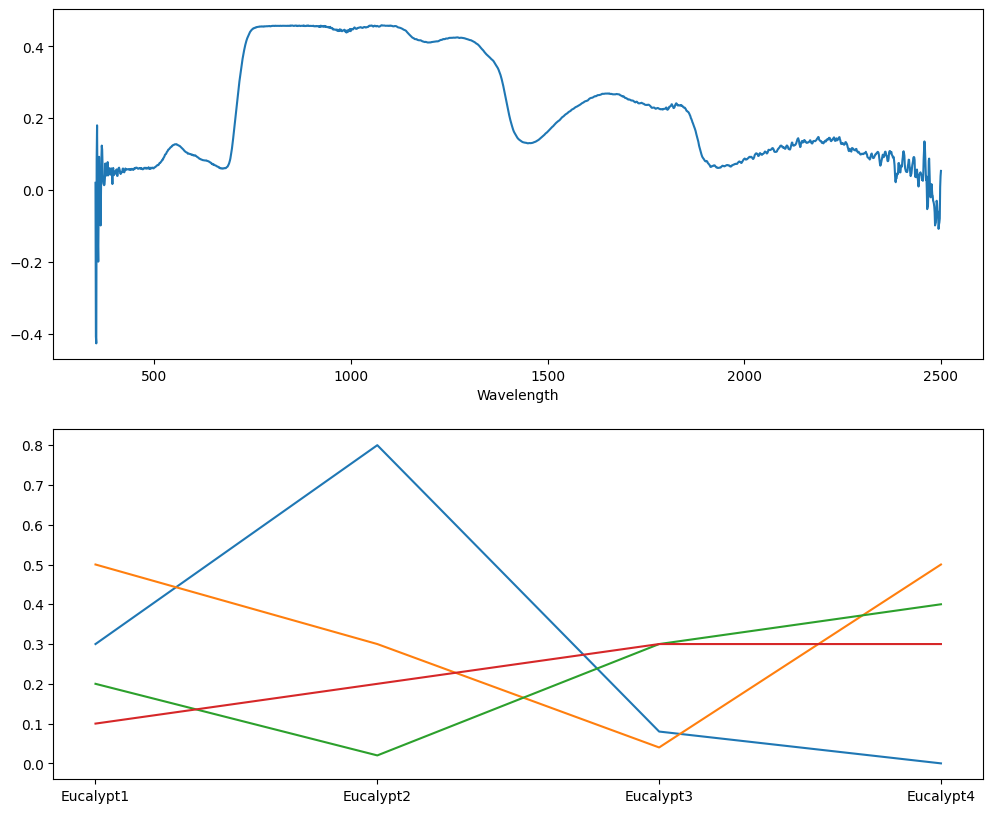

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (12,10))

# plot the simulated spectra
df_cab.plot.line(x='Wavelength', y=['Chloro_4','Chloro_80'], ax=ax)

# Plot the measured spectra
measured_spectra1.plot.line(ax=ax1)

# plot the Sentinel 2 spectra
for index, row in df_sentinel.iterrows():
    ax2.plot(row, label = row.name)

ax1.get_legend().remove()

plt.show()

***

<div class="alert alert-block alert-danger">
    Exercise 1: compare the measured and simulated spectra with the spectra from Sentinel 2
    
- Describe the main differences between the three spectra.
- Can you tell the difference between two different vegetation types using only the Sentinel 2 spectra?
- What are the advantages of using Sentinel 2 data over field or simulated spectra?
- What are the advantages of using field or simulated spectra over Sentinel 2 data?

</div>  

***
## Additional information

**License:** The code in this notebook was modified by Nicolas Younes and Chad Burton. The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 

**Contact:** If you need assistance, please post a question on the ENGN3903 Wattle site 

**Last modified:** October 2023